# Data

## Dataset

In [188]:
import os
import json
import torch
import random
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import savgol, hand_minmax_scale

label_names = ['AA_SN_X', 'AA_SN_Y', 'AA_SN_Z', 'GH_AA_X', 'GH_AA_Y', 'GH_AA_Z']

class Sensor2AngleDataset(Dataset):
    def __init__(self, dataDir, windowLength):
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample, angleSample = self.data[index]
        return sensorSample, angleSample
    
    def load_data(self, dataDir, windowLength, doStandardize=False, doFilter=True):
        sensorPath = Path(dataDir) / "sensor.npy"
        anglePath = Path(dataDir) / "angle.npy"
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        with open(anglePath, 'rb') as f:
            angleAll = np.load(f)
        assert sensorAll.shape[0] == angleAll.shape[0]
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll, angleAll = self.filter_sensor_and_angle(sensorAll, angleAll)
        sensorWindowsAll, angleWindowsAll = self.sliding_window(sensorAll, angleAll, windowLength)
        datasetList = []
        for sensorSample, angleSample in zip(sensorWindowsAll, angleWindowsAll):
            datasetList.append([sensorSample, angleSample]) 
        return datasetList
    
    def standardize_sensor(self, sensorAll):
        # TODO
        # sensor-wize standarize
        sensorAllStd = np.array(list(map(hand_minmax_scale, sensorAll)))
        # time-wise standardize
#         scalerStd = StandardScaler()
#         sensorStd = scalerStd.fit_transform(sensorAll)
        return sensorAllStd

    def filter_sensor_and_angle(self, sensorAll, angleAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        angleFlt = []
        for i in range(angleAll.shape[1]):
            title = label_names[i]
            angleAll[:,i] = savgol(angleAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll, angleAll
    
    def sliding_window(self, sensorAll, angleAll, windowLength):
        senserAllWindows = []
        angleAllWindows = []
        assert(sensorAll.shape[0] == angleAll.shape[0])
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            _y = angleAll[i+windowLength-1]
            senserAllWindows.append(_x)
            angleAllWindows.append(_y) 
        return senserAllWindows, angleAllWindows

ImportError: cannot import name 'hand_minmax_scale' from 'utils' (/Users/hyd/Documents/Research/SholderSensor/ShoulderSensor/utils.py)

In [162]:
sensorPath = Path('./data') / "sensor.npy"
with open(sensorPath, 'rb') as f:
    sensorAll = np.load(f)

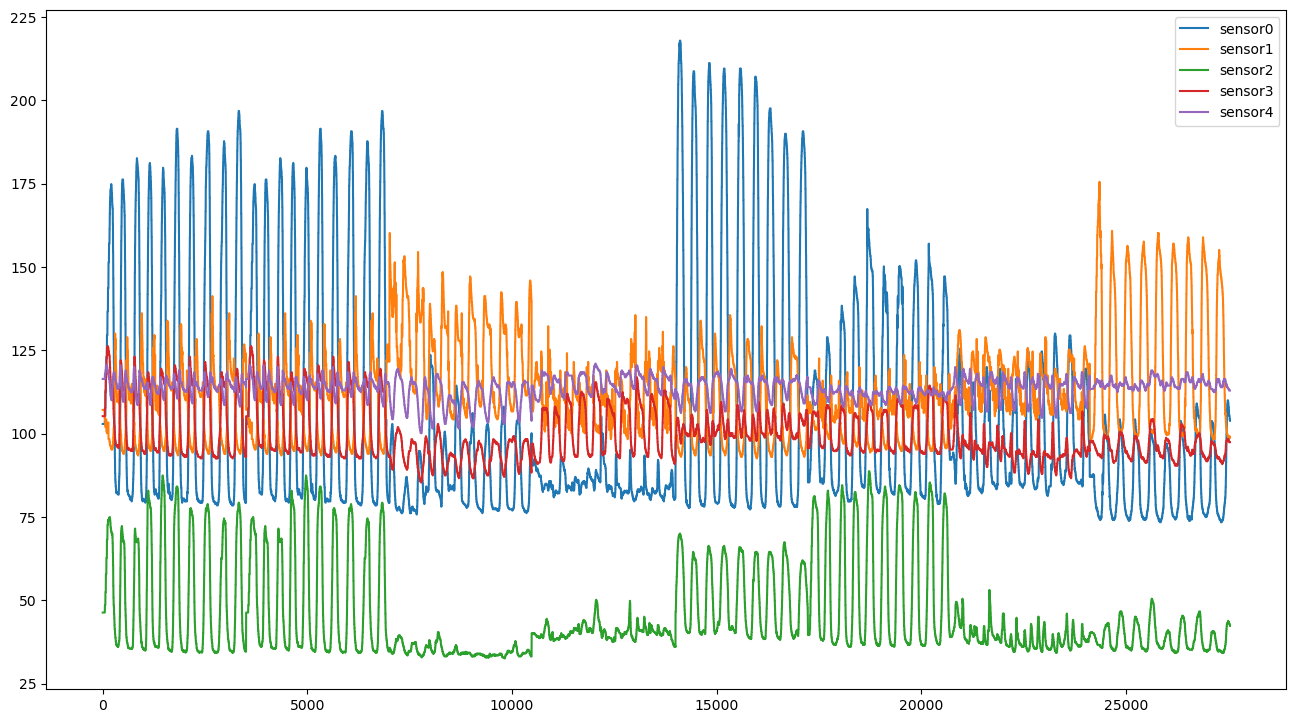

In [170]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 9), dpi=100)
for i in range(5):
    plt.plot(sensorAll[:,i], label=f'sensor{i}')
plt.legend()
plt.show()

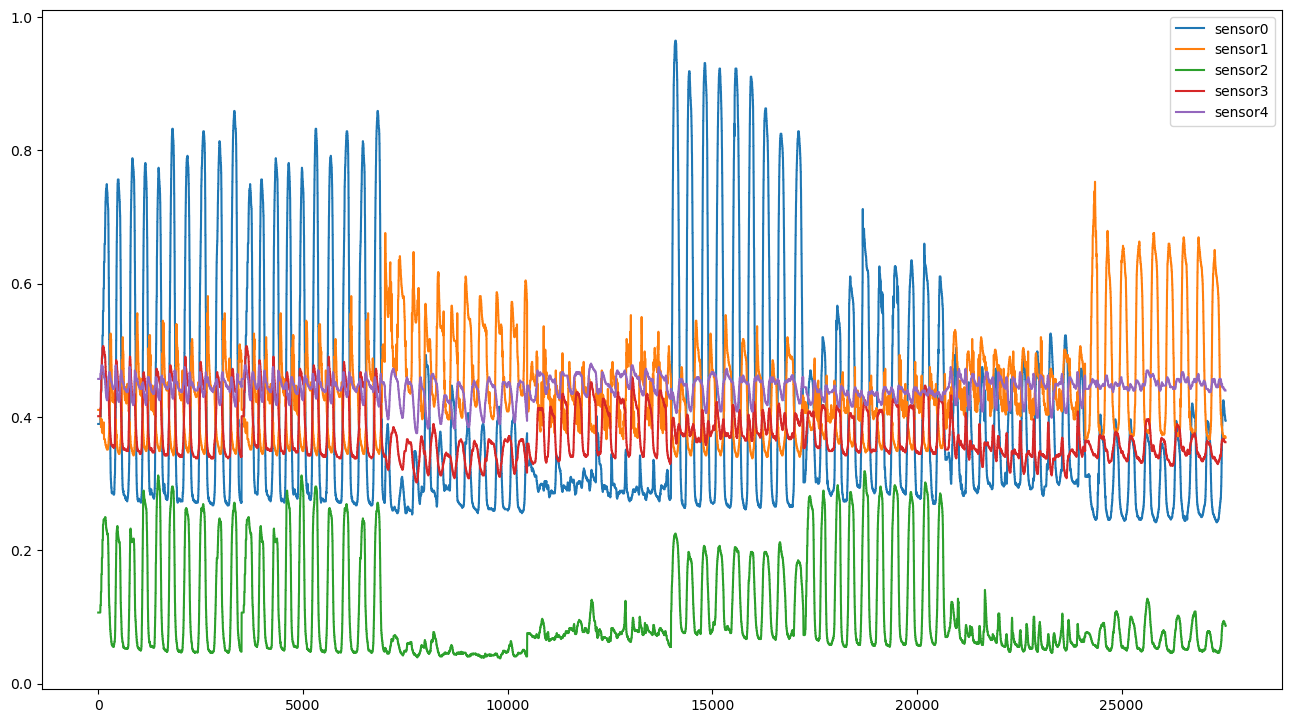

In [184]:

sensorAllStd = np.array(list(map(hand_minmax_scale, sensorAll)))

figure(figsize=(16, 9), dpi=100)
for i in range(5):
    plt.plot(sensorAllStd[:,i], label=f'sensor{i}')
plt.legend()
plt.show()

In [171]:
for s in sensorAll:
    scalerStd = MinMaxScaler()
    s = s.reshape(-1,1)
    print(scalerStd.fit_transform(s))

[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80719281]
 [0.8674183 ]
 [0.        ]
 [0.84044527]
 [1.        ]]
[[0.80

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [106]:
import torch
from torch.utils.data import DataLoader, random_split

def collate_batch(batch):
    # Process features within a batch.
    """Collate a batch of data."""
    sensor, angle = zip(*batch)
    return torch.FloatTensor(sensor), torch.FloatTensor(angle)


def get_dataloader(data_dir, windowLength, batch_size, n_workers):
    """Generate dataloader"""
    dataset = Sensor2AngleDataset(data_dir, windowLength)
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)
    
    train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=False,
    collate_fn=collate_batch,
    )

    return train_loader, valid_loader

# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).